# First-Year Writing Seminars

**Objectives:**
* Assign students to FWS sections so that they get one of their top 5 choices.
* Improve assignments by making changes to our transportation formulation.

**Key Ideas:**
* integrality property
* the transportation problem
* the assignment problem

**Brief description:** If you recall pre-enroll, there was a separate ballot you completed by listing your top 5 picks for FWS that semester. You were later notified which class you got placed into, probably hoping it was your first choice. By now, this should not seem like magic; problems like these often enlist help from Operations Research especially as the scale increases. Disclaimer: the following model is not actually used by Cornell.

In [1]:
# imports -- make sure to run this cell
import pandas as pd
import math, itertools
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
from networkx.algorithms import bipartite
from fws_lab import *
from ortools.linear_solver import pywraplp as OR

## Part 1: Brainstorming

We want to *assign* a class to each student. This sounds like an assignment problem, which is a special case of the *transportation problem*. 

**Example 1**  
The following table gives an instance with 7 students (1-7) and 4 classes (A-D). Each class has a capacity of 2 students. Column `1` gives the student's first preference and `2` gives their second preference.

In [2]:
fws_7_students = pd.read_csv('data/fws_7_students.csv', index_col=0)
display(fws_7_students)

,1,2
student,,
1,A,B
2,D,C
3,A,C
4,B,D
5,C,B
6,A,B
7,B,A


**Q1:** What are the supply nodes?  

**A:** <font color='blue'>Students</font>  

**Q2:** What are the supply values of the supply nodes? (Hint: How many units can be transferred?)

**A:** <font color='blue'>1</font>  

**Q3:** What are the demand nodes?  

**A:** <font color='blue'>Classes</font>  

**Q4:** What are the demand values of the demand nodes? (Hint: How many units can be received?)

**A:** <font color='blue'> The capcity of the class the demand node represents. In this case, 2</font>  

**Q5:** What does a directed edge from a supply node to a demand node indicate?  

**A:** <font color='blue'>The student represented by the supply node could potentially be assigned to the class represented by the supply node.</font>

**Q6:** What are the edge costs?  

**A:** <font color='blue'> The edge cost from the student to their first choice is 1 and the edge cost from the student to their second choice is 2 since we want to minimize cost.</font>

**Q7:** Visualize your graph by completing the dictionary of edge costs. This will be used later as the input to the LP model.

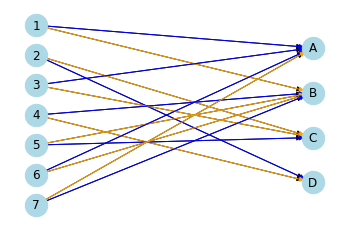

In [3]:
# TODO: Uncomment and complete the dictionary of edge costs
# S = [1,2,3,4,5,6,7]
# D = ['A','B','C','D']
# E = {(1,'A'):1, 
#      (1,'B'):2, 
#      (2,'D'): , 
#      (2,'C'): , 
#      (3,'A'): , 
#      (3,'C'): , 
#      (4,'B'): , 
#      (4,'D'): , 
#      (5,'C'): , 
#      (5,'B'): , 
#      (6,'A'): , 
#      (6,'B'): , 
#      (7,'B'): , 
#      (7,'A'):  }

### BEGIN SOLUTION
S = [1,2,3,4,5,6,7]
D = ['A','B','C','D']
E = {(1,'A'):1, 
     (1,'B'):2, 
     (2,'D'):1, 
     (2,'C'):2, 
     (3,'A'):1, 
     (3,'C'):2, 
     (4,'B'):1, 
     (4,'D'):2, 
     (5,'C'):1, 
     (5,'B'):2, 
     (6,'A'):1, 
     (6,'B'):2, 
     (7,'B'):1, 
     (7,'A'):2 }
### END SOLUTION

ex1(S, D, E)

To complete the simple model, we need to answer one more question.  

**Q8:** The total demand is 8, but the current total supply is only 7. How can we make sure that demand is satisfied for there to be a feasible solution?  

**A:** <font color='blue'>Add a dummy node and edges going from it to every class node with cost 3</font>  

**Q9:** Create a similar list of students, classes, and edge weights like the lists above but account for the dummy supply node (which is indexed as zero).

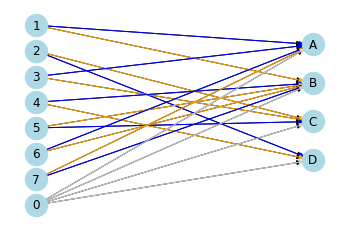

In [4]:
# TODO: Uncomment and complete the dictionary of edge costs
# S_dummy = [1,2,3,4,5,6,7,0]
# D_dummy = ['A','B','C','D']
# E_dummy = {(1,'A'):1, (1,'B'):2, (2,'D'):1, (2,'C'):2, (3,'A'):1, (3,'C'):2, 
#            (4,'B'):1, (4,'D'):2, (5,'C'):1, (5,'B'):2, (6,'A'):1, (6,'B'):2, 
#            (7,'B'):1, (7,'A'):2, (0,'A'): XXX, (0,'B'): XXX, (0,'C'): XXX, (0,'D'): XXX}

### BEGIN SOLUTION
S_dummy = [1,2,3,4,5,6,7,0]
D_dummy = ['A','B','C','D']
E_dummy = {(1,'A'):1, (1,'B'):2, (2,'D'):1, (2,'C'):2, (3,'A'):1, (3,'C'):2, 
           (4,'B'):1, (4,'D'):2, (5,'C'):1, (5,'B'):2, (6,'A'):1, (6,'B'):2, 
           (7,'B'):1, (7,'A'):2, (0,'A'):3, (0,'B'):3, (0,'C'):3, (0,'D'):3}
### END SOLUTION

ex1(S_dummy, D_dummy, E_dummy)

## Part 2: Solving

Let's use OR-Tools to define our mathematical model. 

**Q10:** Complete the constraints in the cell below.

In [5]:
def fws(preferences, capacity, cost, integer = False):
    """A model for solving a first-year writing seminar assignment problem.
    
    Args:
        preferences (pd.DataFrame): Preferred classes for each student.
        capacity (int): Capacity of the classroom.
        cost (Dict): Dictionary from edges types to cost.
    """
    STUDENTS = list(preferences.index) + ['dummy']             # students
    
    CLASSES = []
    for c in preferences.columns:
        CLASSES = CLASSES + list(preferences[c].unique())
    CLASSES = list(set(CLASSES))                               # classes
    
    edge_costs = {}                                 
    for s in preferences.index:
        for c in preferences:
            edge_costs[(s, preferences.at[int(s),c])] = cost[int(c)]
    EDGES = list(edge_costs)                                   # edges
    
    # add dummy edges
    dummy_edges = list(itertools.product(['dummy'], CLASSES))
    EDGES.extend(dummy_edges)          
    
    c = edge_costs                                             # costs
    # add dummy edge costs
    for edge in dummy_edges:
        c.update({edge : cost['dummy']})    
    
    # define model
    m = OR.Solver('fws', OR.Solver.CBC_MIXED_INTEGER_PROGRAMMING)
    
    # decision variables
    x = {}    
    for i,j in EDGES:
        if integer:
            x[i,j] = m.IntVar(0, m.infinity(), ('(%s, %s)' % (i,j)))
        else:
            x[i,j] = m.NumVar(0, m.infinity(), ('(%s, %s)' % (i,j)))
        
    # objective function
    m.Minimize(sum(c[i,j]*x[i,j] for i,j in EDGES))
       
    # subject to: each student (not including the dummy) is assigned at most one class
    for k in STUDENTS:
        if k != 'dummy':
            m.Add(sum(x[i,j] for i,j in EDGES if i==k) <= 1)
        
    # subject to: each class is full
    # TODO: Write the constraint that each class is full
    
    ### BEGIN SOLUTION
    for k in CLASSES:
        m.Add(sum(x[i,j] for i,j in EDGES if j==k) == capacity)
    ### END SOLUTION
    
    return m,x

In [6]:
def solution_summary(preferences, x):
    '''Get the counts of every assigned preference for some solution.'''
    counts = {int(i):0 for i in list(preferences.columns)}
    unassigned = 0
    matches = {k[0] : k[1] for k,v in x.items() if v.solution_value() == 1.0}
    for index, row in preferences.iterrows():
        class_to_rank = {v:k for k,v in row.to_dict().items()}
        if index in matches:
            pref=int(class_to_rank[matches[index]])
            counts[pref] += 1
        else:
            unassigned +=1
    print("Unmatched students:", unassigned)
    return counts

**Q11:** Replace `XXX` with the cost of the dummy edges and then run the cell.

In [7]:
# TODO: Uncomment and replace XXX with the cost of the dummy edges
# costs = {1:1, 2:2, 'dummy':XXX}

### BEGIN SOLUTION
costs = {1:1, 2:2, 'dummy':3}
### END SOLUTION

m,x = fws(fws_7_students, 2, costs)
m.Solve()
solution_summary(fws_7_students, x)

Unmatched students: 0


{1: 6, 2: 1}

6 students got their first choice, 1 student got their second choice, and no students were left unmatched.   

**Q12:** Why can't all the students be assigned their first choice? Or do you think the answer you got could be better?  

**A:** <font color='blue'>Limited capacity of classes</font> 

**Example 2**  
In this new instance with 8 students (1-8) and 4 classes (A-D), more students prefer A and B than C and D.

In [8]:
fws_8_students = pd.read_csv('data/fws_8_students.csv', index_col=0)
display(fws_8_students)

,1,2
student,,
1,A,B
2,B,A
3,C,D
4,A,B
5,B,A
6,A,C
7,C,D
8,A,D


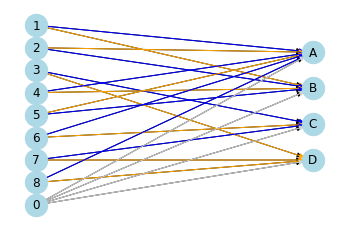

In [9]:
S2 = [1,2,3,4,5,6,7,8]
D2 = ['A','B','C','D']
E2 = {(1,'A'):1, (1,'B'):2, (2,'B'):1, (2,'A'):2, (3,'C'):1, (3,'D'):2, (4,'A'):1, (4,'B'):2, 
      (5,'B'):1, (5,'A'):2, (6,'A'):1, (6,'C'):2, (7,'C'):1, (7,'D'):2, (8,'A'):1, (8,'D'):2}

ex2(S2, E2)

In [10]:
# cost of edges from dummy node is 2.5
costs = {1:1, 2:2, 'dummy':2.5}
m,x = fws(fws_8_students, 2, costs)
m.Solve()
solution_summary(fws_8_students, x)

Unmatched students: 1


{1: 6, 2: 1}

There is 1 unmatched student when using 2.5 as the cost of dummy edges.  

**Q13:** Why can't all the students be assigned one of their top 2 choices? Or do you think the answer you got could be better?  

**A:** <font color='blue'>By adjusting the cost of an unmatched student, we can find an assignment in which all students are matched to a class.</font>  

Re-solve using 3.5 as the cost.

In [11]:
costs = {1:1, 2:2, 'dummy':3.5}
m,x = fws(fws_8_students, 2, costs)
m.Solve()
solution_summary(fws_8_students, x)

Unmatched students: 0


{1: 5, 2: 3}

**Q14:** Both the edge weights 2.5 and 3.5 are greater than 2. In some sense, they are prioritized last. We rather send flow across 1 and 2 weight edges. However, we get different solutions. Why?

**A:** <font color='blue'>The combined cost of a first pick edge and a dummy edge versus two second pick edges is  $1+2.5 < 2+2$ (edge cost 2.5) while is it $1+3.5 > 2+2$ (edge cost 3.5) </font>  

When solving the actual data, you will see that other subtle reasons might lead to unmatched students.

## Part 3: Solving the Actual Data

There are 2886 students and 183 class sections. Assume each class can have at most 16 students. As we already know, each student picks their top 5 classes.

In [12]:
fws_f09_ballots = pd.read_csv('data/fws_f09_ballots.csv', index_col=0)
fws_f09_ballots.head()

,1,2,3,4,5
students,,,,,
1,145,142,125,143,80
2,72,12,149,171,8
3,79,87,37,120,97
4,104,101,103,100,99
5,26,154,149,101,28


There are 6 columns with the first being student # and the other 5 being first, second, third, fourth, and fifth choice. Each row is a student, and class # indicates the class picked as the choice belonging to the column.

Unmatched students: 107


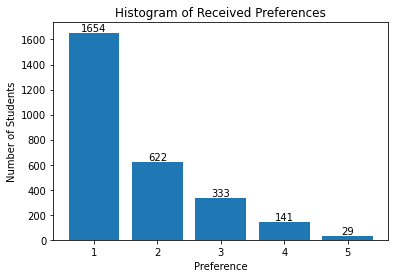

In [13]:
costs = {1:1, 2:2, 3:3, 4:4, 5:5, 'dummy':6}
m,x = fws(fws_f09_ballots, 16, costs)
m.Solve()
original  = solution_summary(fws_f09_ballots, x)
Histo(original, 15)

We got an answer! Unfortunately, there are 107 students who did not get any of their top 5 picks. Let's improve our model, so that no students are unmatched.  

The objective function is actually a weighted function. The coefficients dictate how desirable each of the corresponding edges are. An edge with a small cost (weight) has a higher likelihood of being in the solution while an edge with a large cost will potentially be avoided.

Let's leave the costs for the first - fifth choices (1-5) the same but set the cost of edges from the dummy node to an arbitrarily large number like 100,000. These edges are now very likely to be avoided in a solution.

**Q15:** What is the real-world interpretation of having less edges from the dummy node in the solution?

**A:** <font color='blue'> If less edges from the dummy node are in the solution, less courses have a dummy student in them. Hence, more students are getting one of their top 5 preferred courses. </font>  

**Q16:** Set the cost of the dummy edges to 100,000. How many students are unmatched now?

**A:** <font color='blue'> There are now 0 unmatched students! </font>  

Unmatched students: 0


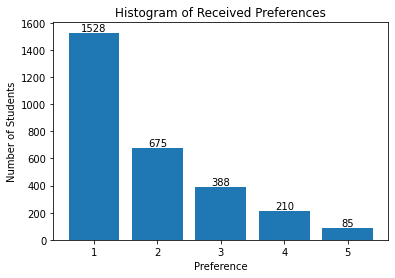

In [14]:
# TODO: Set the cost of the dummy edges to 100,000
#costs = {1:1, 2:2, 3:3, 4:4, 5:5, 'dummy':XXX}

### BEGIN SOLUTION
costs = {1:1, 2:2, 3:3, 4:4, 5:5, 'dummy':100000}
### END SOLUTION

m,x = fws(fws_f09_ballots, 16, costs)
m.Solve()
large_dummy_weight  = solution_summary(fws_f09_ballots, x)
Histo(large_dummy_weight, 15)

**Q17:** Compare the distribution of received student preferences between our original solution and the new one with zero unmatched students.

**A:** <font color='blue'> All students are now matched but the distribution is less skewed towards the first preference. Less students got their first or second preference and more got their third - fifth preference. </font>  

You may have mentioned that less students got their first choice. What if we want a solution that maximizes the number of students receiving their first choice, then maximizes those receiving their second choice, and so on all subject to the number of unmatched students being minimized (in this case, we know there should be zero unmatched students). It turns out we can acheive some complex behavior like this by just setting our weights cleverly.

By setting the weight of the dummy edges to be multiple orders of magnitude greater than the other edge weights, we essentially acheived a model that first minimizes the number of unmatched students without thinking about any preferences. This is because a student being matched or unmatched has a significantly larger effect on the value of a solution than which preference and student receives. We can apply this same approach again! 

We will use a dummy cost of 100,000 again. Now, we want to maximize the number of first preferences received. To do this, we set the cost of these edges to a large negative value an order of magnitude less than the cost of the dummy edges: -10,000. We set the remaining edge weights in the same fashion.

**Q18:** Choose the correct edge weights for the second through fifth preference edges. 

Unmatched students: 0


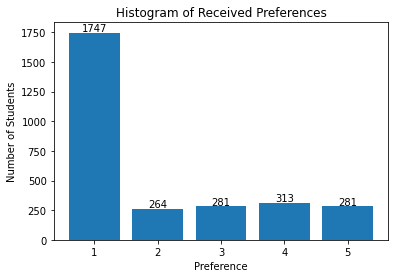

In [15]:
# TODO: Choose the correct edge weights
# costs = {1:-10000, 2:XXX, 3:XXX, 4:XXX, 5:XXX, 'dummy':100000}

### BEGIN SOLUTION
costs = {1:-10000, 2:-1000, 3:-100, 4:-10, 5:0, 'dummy':100000}
### END SOLUTION

m,x = fws(fws_f09_ballots, 16, costs)
m.Solve()
max_lexico  = solution_summary(fws_f09_ballots, x)
Histo(max_lexico, 15)

**Q19:** How does the number of students with their first preference compare to the previous solutions? What was the number of unmatched students? Comment on the distribution you observe.

**A:** <font color='blue'> This solution had nearly 100 more first preferences met with 1747 while maintaining zero unmatched students. All of these first preferences restricted the solution greatly so the remaining students are relatively evenly distributed among prefernces 2-5.</font>  

What if we want to have the opposite approach. Again, we want to minimize unmatched students. However, rather than maximizing the number of students who recieive their first preference next, we want to minimize the number of students who recieive their last (fifth) preference. Then, we minimize the number of students who recieive their fourth preference and so on.

**Q20:** Choose costs that achieve the described objective. (Hint: Use different orders of magnitude to choose the order in which objectives are considered. Negative edge weights are like maximizing and positive edge weights are like minimizing)

Unmatched students: 0


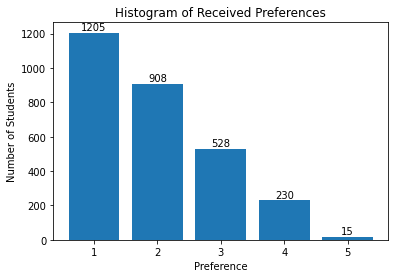

In [16]:
# TODO: Choose costs that achieve the described objective.
# costs = {1:XXX, 2:XXX, 3:XXX, 4:XXX, 5:XXX, 'dummy':XXX}

### BEGIN SOLUTION
costs = {1:0, 2:10, 3:100, 4:1000, 5:10000, 'dummy':100000}
### END SOLUTION

m,x = fws(fws_f09_ballots, 16, costs)
m.Solve()
min_lexico  = solution_summary(fws_f09_ballots, x)
Histo(min_lexico, 15)

**Q21:** How does the number of students with their fifth preference compare to the previous solutions? Compare this solution to the other solutions.

**A:** <font color='blue'> This solution has zero unmatched students and has only 15 students with their fifth preference. Becuase the model is more restricted as it considers higher prefernces, the number of students with their first preference is significantly less at only 1205.</font>  

As you can see, there are a wide variety of solutions with zero unmatched students. How did the Knight Institute choose a solution? They opted to do a combination of the previous two models. The number of fifth and then fourth preferences were minimized and then the number of first, second, and then third preferences was then maximized. Let's see the solution! 

Unmatched students: 0


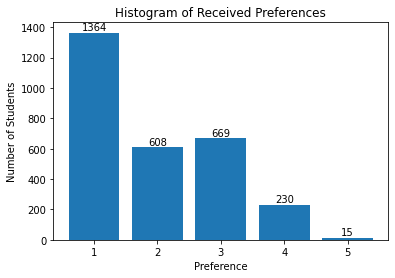

In [17]:
costs = {1:-100, 2:-10, 3:0, 4:1000, 5:10000, 'dummy':100000}
m,x = fws(fws_f09_ballots, 16, costs)
m.Solve()
knight  = solution_summary(fws_f09_ballots, x)
Histo(knight, 15)

**Q22:** Compare this solution to the previous solutions. Do you think the Knight Institute made the right decision? How would you have done it differently?

**A:** <font color='blue'> We can see this solution has the minimum number of fouth and fifth preferences received but then maximizes the number of first prefernces achieving nearly 160 more first prefernces satisfied than the previous solution. As a result, there are less second preferences but more third prefernces.</font>  

<font color='red'> This could be explained better.</font>

In each of the previous models, we set the weights of different edges at different orders of magnitude to essentially order our objectives. However, an order of magnitude seems arbitrary. How can we show exactly what multiplier needs to  be used to prove the model is giving us the solution we want?

Let's consider a simple example in which there is only one prefernce which is either met or not. We want to minimize unmatched. Let's assume we have 100 students that must be assigned. We need to choose weights $w_1$ and $w_{\text{dummy}}$.

**Q23:** If one student is unmatched, what is the maximum total weight the other 100 students can acheive?

**A:** <font color='blue'> $99w_1$</font>  

**Q24:** Using your answer to **Q23**, give an inequality that your weights must abide by.

**A:** <font color='blue'> $99w_1 < w_{\text{dummy}}$</font>  

**Q25:** What multiplier needs to be used to ensure that the number of unmatched students is minimized?

**A:** <font color='blue'> $100$</font>  

<font color='red'> **TODO:** IP from adding section minimum constraint.</font>

## Bonus 1

We do not want to waste time trying different cost combinations if there is no solution where every student gets one of their top 5 picks. How can we check whether there exists a feasible solution with 0 unmatched students?  

**B1:** What is the cost of edges representing students' preferences?  

**A:** <font color='blue'>0</font>  

**B2:** What is the cost of dummy edges?  
    
**A:** <font color='blue'>1</font>  

**B3:** What is the desired solution?  

**A:** <font color='blue'>Zero cost assignment</font>  

**B4:** Describe another way that might use a different model.  

**A:** <font color='blue'>e.g. max flow</font>  